# Multiclass SVM

If we have more than 2 classes to classify Multiclass classification is needed.
There are 2 main technics to this kind of problem:
- one vs one
    - Using a binary classifier for every pair of possible classes. Finally the category with more votes is selected.
    - With $k$ categories, we create ${k\choose 2} = \frac{k!}{(k-2)!2!}$ classifiers.
- one vs all
    - Creating one classifier for each class.
    - With $k$ categories, then classify $C_1$ or **no** $C_1$, $C_2$ or **no** $C_2$,...,$C_k$ or **no** $C_k$

## Library and dataset import

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import datasets

session = tf.Session()
%config Completer.use_jedi = False

In [3]:
iris = datasets.load_iris()

x_vals = np.array([[x[0], x[3]] for x in iris.data])
y_vals1 = np.array([1 if y == 0 else -1 for y in iris.target])
y_vals2 = np.array([1 if y == 1 else -1 for y in iris.target])
y_vals3 = np.array([1 if y == 2 else -1 for y in iris.target])

class1_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i] == 0]   #For each class create a variable (2dimentional)
class1_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i] == 0]

class2_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i] == 1]
class2_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i] == 1]

class3_x = [x[0] for i, x in enumerate(x_vals) if iris.target[i] == 2]
class3_y = [x[1] for i, x in enumerate(x_vals) if iris.target[i] == 2]

y_vals = np.array([y_vals1, y_vals2, y_vals3])

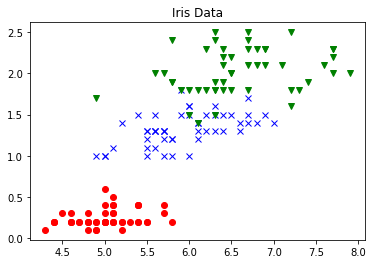

In [4]:
plt.plot(class1_x, class1_y, 'ro', label = 'Setosa')
plt.plot(class2_x, class2_y, 'bx', label = 'Versicolor')
plt.plot(class3_x, class3_y, 'gv', label = 'Virginica')
plt.title('Iris Data')
plt.show()

## Variable creation

In [5]:
batch_size = 150
x_data = tf.placeholder(shape = [None, 2], dtype = tf.float32)
y_target = tf.placeholder(shape = [3, None], dtype = tf.float32)
prediction_grid = tf.placeholder(shape = [None, 2], dtype = tf.float32)

b = tf.Variable(tf.random_normal(shape = [3, batch_size]))

### Gaussian Kernel

In [7]:
gamma = tf.constant(-10.0)
dist = tf.reduce_sum(tf.square(x_data), 1)
dist = tf.reshape(dist, [-1,1])
sq_dist = tf.add(tf.subtract(dist, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(x_data)))), tf.transpose(dist))
my_kernel = tf.exp(tf.multiply(gamma, tf.abs(sq_dist)))

### General Solution
Previously for 2 classes the $b_i\cdot b_j$ was $x^T\cdot x$.
But now, with +2 classes we have a different aproach.

In [8]:
def reshape_matmul(mat):
    v1 = tf.expand_dims(mat, 1)
    v2 = tf.reshape(v1, [3, batch_size, 1])
    return tf.matmul(v2, v1)

In [9]:
first_term = tf.reduce_sum(b)
b_vec_cross = tf.matmul(tf.transpose(b), b)
y_target_cross = reshape_matmul(y_target)

second_term = tf.reduce_sum(tf.multiply(my_kernel, tf.multiply(b_vec_cross, y_target_cross)), [1, 2])
loss = tf.reduce_sum(tf.negative(tf.subtract(first_term, second_term)))

### Prediction Kernel

In [19]:
rA = tf.reshape(tf.reduce_sum(tf.square(x_data), 1), [-1, 1])
rB = tf.reshape(tf.reduce_sum(tf.square(prediction_grid), 1), [-1, 1])

pred_sq_dist = tf.add(tf.subtract(rA, tf.multiply(2.0, tf.matmul(x_data, tf.transpose(prediction_grid)))), tf.transpose(rB))
pred_kernel = tf.exp(tf.multiply(gamma, tf.abs(pred_sq_dist)))

prediction_output = tf.matmul(tf.multiply(y_target, b), pred_kernel)
prediction = tf.argmax(prediction_output - tf.expand_dims(tf.reduce_mean(prediction_output, 1), 1), 0)

accuracy = tf.reduce_mean(tf.cast(tf.equal(prediction, tf.argmax(y_target, 0)), tf.float32))


### Train algorithm

In [20]:
my_opt = tf.train.GradientDescentOptimizer(0.01)
train_step = my_opt.minimize(loss)

### Variable initializer

In [45]:
init = tf.global_variables_initializer()
session.run(init)

## Model training

Step #25Loss = 27.341333Accuracy = 0.82
Step #50Loss = -30.179585Accuracy = 0.9066667
Step #75Loss = -35.47976Accuracy = 0.94666666
Step #100Loss = -37.36814Accuracy = 0.9533333
Step #125Loss = -37.255917Accuracy = 0.9533333
Step #150Loss = -33.18155Accuracy = 0.93333334
Step #175Loss = -30.440361Accuracy = 0.9866667
Step #200Loss = -35.21Accuracy = 0.96


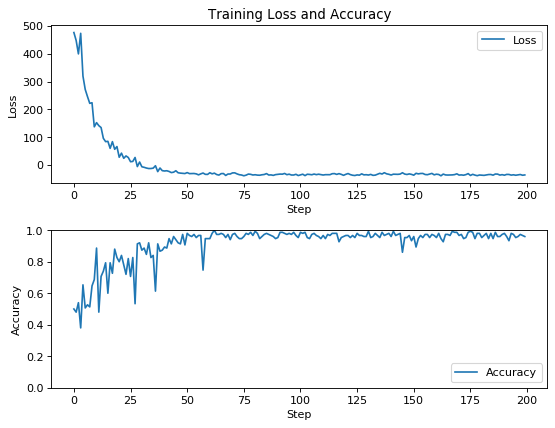

In [46]:
loss_vect = []
batch_acc = []

for i in range(200):
    rand_idx = np.random.choice(len(x_vals), size = batch_size)
    rand_x = x_vals[rand_idx]
    rand_y = y_vals[:, rand_idx]
    session.run(train_step, feed_dict = {x_data: rand_x,
                                        y_target: rand_y})
    temp_loss = session.run(loss, feed_dict = {x_data: rand_x,
                                               y_target: rand_y})
    loss_vect.append(temp_loss)
    
    temp_acc = session.run(accuracy, feed_dict = {x_data: rand_x,
                                                y_target: rand_y,
                                                prediction_grid: rand_x})
    batch_acc.append(temp_acc)
    
    if(i+1)%25 == 0:
        print('Step #'+str(i+1)+
              'Loss = '+str(temp_loss)+
              'Accuracy = '+str(temp_acc))

plt.figure(figsize=(8, 6), dpi=80)
plt.subplots_adjust(hspace= 0.3)

plt.subplot(2,1,1)
plt.title('Training Loss and Accuracy')
plt.plot(loss_vect, label = 'Loss')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.legend(loc = 'upper right')

plt.subplot(2,1,2)
plt.plot(batch_acc, label = 'Accuracy')
plt.xlabel('Step')
plt.ylabel('Accuracy')
plt.legend(loc = 'lower right')
plt.ylim([0, 1])

plt.show()

## Result visualization

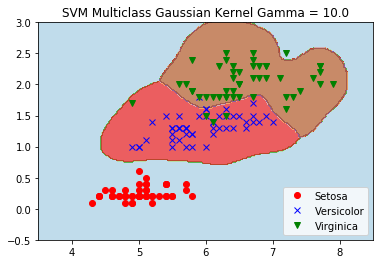

In [28]:
x_min, x_max = x_vals[:,0].min()-1, x_vals[:,0].max()+1
y_min, y_max = x_vals[:,1].min()-1, x_vals[:,1].max()+1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
grid_points = np.c_[xx.ravel(), yy.ravel()]

grid_predictions = session.run(prediction, feed_dict = {x_data: rand_x,
                                                        y_target: rand_y,
                                                        prediction_grid: grid_points})
grid_predictions = grid_predictions.reshape(xx.shape)

plt.contourf(xx, yy, grid_predictions, cmap = plt.cm.Paired, alpha = 0.7)
plt.plot(class1_x, class1_y, 'ro', label = 'Setosa')
plt.plot(class2_x, class2_y, 'bx', label = 'Versicolor')
plt.plot(class3_x, class3_y, 'gv', label = 'Virginica')
plt.legend(loc = 'lower right')
plt.xlim([3.5, 8.5])
plt.ylim([-0.5, 3.0 ])

plt.title('SVM Multiclass Gaussian Kernel Gamma = '+str(-session.run(gamma)))
plt.show()